# This is the code to test the baseline methods for AD

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')
parent_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_path)

import pandas as pd
import torch
import random, argparse
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from TSB_AD.evaluation.metrics import get_metrics
from TSB_AD.utils.slidingWindows import find_length_rank
from TSB_AD.model_wrapper import *
from TSB_AD.HP_list import Optimal_Uni_algo_HP_dict
from sklearn.metrics import f1_score

def find_best_threshold(labels, scores, num_thresholds=100):
    labels = np.array(labels)
    scores = np.array(scores)
    
    thresholds = np.linspace(scores.min(), scores.max(), num_thresholds)
    best_f1 = 0
    best_threshold = thresholds[0]

    for thresh in thresholds:
        preds = (scores > thresh).astype(int)
        f1 = f1_score(labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh

    return best_threshold

# Specify Anomaly Detector to use and data directory
AD_Name = 'CNN'   # It can be replaced with any anomaly detector availale in TSB-AD
data_direc = '../Datasets/TSB-AD-U/'
filename = '032_WSD_id_4_WebService_tr_4559_1st_11822.csv'

df = pd.read_csv(data_direc + filename).dropna()
data = df.iloc[:, 0:-1].values.astype(float)
label = df['Label'].astype(int).to_numpy()

slidingWindow = find_length_rank(data, rank=1)
train_index = filename.split('.')[0].split('_')[-3]
data_train = data[:int(train_index), :]
Optimal_Det_HP = Optimal_Uni_algo_HP_dict[AD_Name]

if AD_Name in Semisupervise_AD_Pool:
    output = run_Semisupervise_AD(AD_Name, data_train, data, **Optimal_Det_HP)
elif AD_Name in Unsupervise_AD_Pool:
    output = run_Unsupervise_AD(AD_Name, data, **Optimal_Det_HP)
else:
    raise Exception(f"{AD_Name} is not defined")

if isinstance(output, np.ndarray):
    output = MinMaxScaler(feature_range=(0,1)).fit_transform(output.reshape(-1,1)).ravel()
    # evaluation_result = get_metrics(output, label, slidingWindow=slidingWindow, pred=output > (np.mean(output)+3*np.std(output)))
    evaluation_result = get_metrics(output, label, slidingWindow=slidingWindow, pred=output > find_best_threshold(label,output))
    print('Evaluation Result: ', evaluation_result)
else:
    print(f'At {filename}: '+output)

----- Using GPU 7 -----


Validation Epoch [2/50]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 479.24it/s, avg_loss=0.727, loss=0.507]


EarlyStopping counter: 1 out of 3


Validation Epoch [3/50]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 479.91it/s, avg_loss=0.737, loss=0.483]


EarlyStopping counter: 2 out of 3


Validation Epoch [4/50]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 479.16it/s, avg_loss=0.735, loss=0.535]


EarlyStopping counter: 3 out of 3
torch.Size([]) torch.Size([])
   Early stopping<<<


Testing: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 614.95it/s]

scores:  (10636,)


Evaluation Result:  {'AUC-PR': 0.22797153992564162, 'AUC-ROC': 0.7708460437394405, 'VUS-PR': 0.10569037630357622, 'VUS-ROC': 0.8595600657424509, 'Standard-F1': 0.2962962962962963, 'PA-F1': 0.8205128205128205, 'Event-based-F1': 0.5333333333333329, 'R-based-F1': 0.0030120481927710845, 'Affiliation-F': 0.8851486851946154}


In [2]:
dataList = data
labelList = label
labelList = labelList.astype('bool')

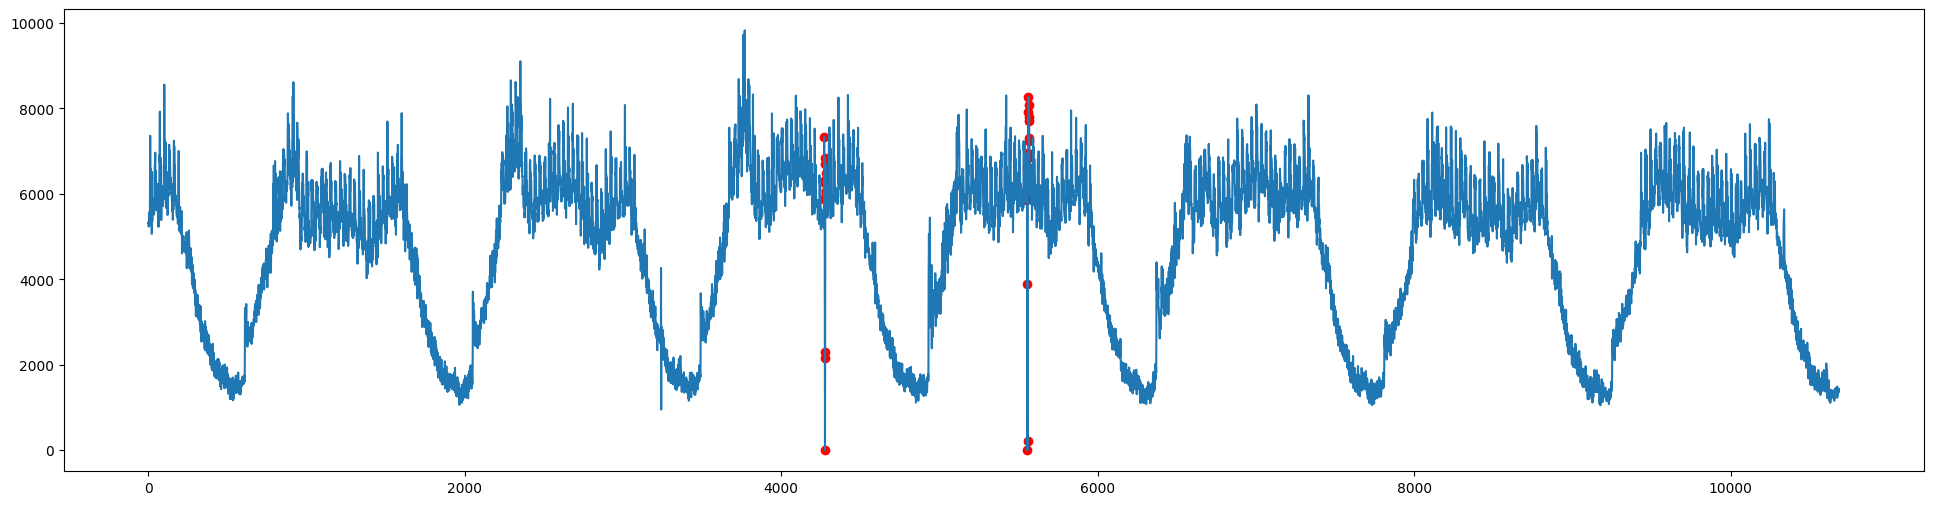

In [3]:
x = np.array(list(range(dataList.shape[0])))
x1 = x[labelList]
y = dataList
y1 = y[labelList]
fig,ax = plt.subplots(figsize = (24,6))
ax.plot(x,y)
ax.scatter(x1,y1,color='r')
#ax.set_xlim(1000,2000)

In [10]:
dataList = data
labelList = output > find_best_threshold(label,output)

In [11]:
def compute_point_f1(labels, preds):
    """
    Compute standard point-level F1 score (no tolerance).
    
    Args:
        labels (np.ndarray): Ground truth binary labels (0 or 1), shape (T,)
        preds (np.ndarray): Predicted binary labels (0 or 1), shape (T,)
        
    Returns:
        precision, recall, f1_score
    """
    labels = np.array(labels)
    preds = np.array(preds)

    TP = np.sum((labels == 1) & (preds == 1))
    FP = np.sum((labels == 0) & (preds == 1))
    FN = np.sum((labels == 1) & (preds == 0))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return precision, recall, f1

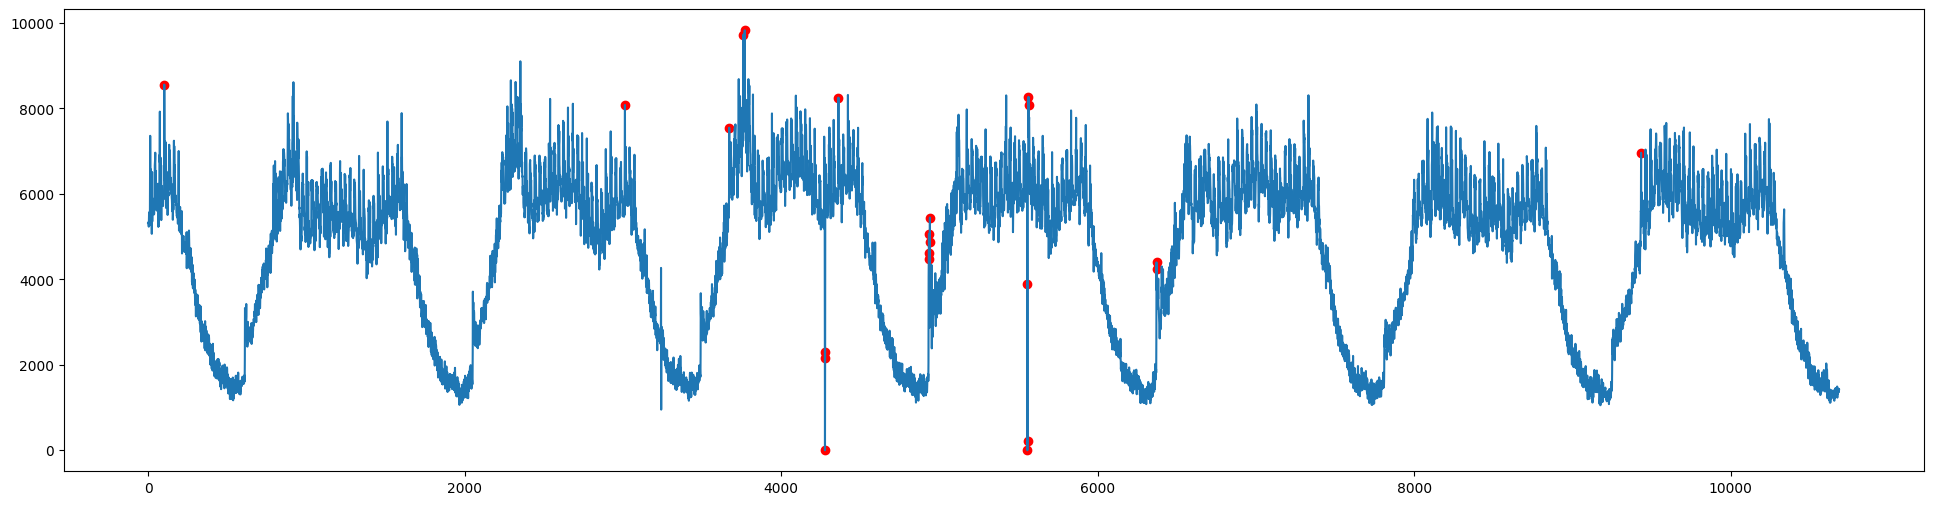

In [13]:
x = np.array(list(range(dataList.shape[0])))
x1 = x[labelList]
y = dataList
y1 = y[labelList]
fig,ax = plt.subplots(figsize = (24,6))
ax.plot(x,y)
ax.scatter(x1,y1,color='r')
#ax.set_xlim(1000,2000)

In [7]:
input1 = label
input2 = labelList.astype(int)

In [8]:
compute_point_f1(input1, input2)

(0.11538461538461539, 0.375, 0.1764705882352941)

In [9]:
find_best_threshold(label,output)

0.13131313131313135